In [1]:
import ctypes
import ctypes.util
ctypes.CDLL(ctypes.util.find_library('GL'), ctypes.RTLD_GLOBAL)

<CDLL 'libGL.so.1', handle 558d12d57a90 at 0x7f0a6c696500>

In [2]:
# The basic mujoco wrapper.
from dm_control import mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite

# Run through corridor example
from dm_control.locomotion.walkers import cmu_humanoid, ant
from dm_control.locomotion.arenas import corridors as corridor_arenas, mazes as maze_arenas
from dm_control.locomotion.tasks import corridors as corridor_tasks, RepeatSingleGoalMaze, RepeatSingleGoalMazeAugmentedWithTargets

# Soccer
from dm_control.locomotion import soccer

# Manipulation
from dm_control import manipulation
import labmaze
from dm_maze.dm_wrapper import DMEnvWrapper
from dm_maze.dm_maze import DM_Maze_Task, DM_Maze_Arena, DM_Maze_Env

/mnt/7076984276980B4C/ssd_backup/ActiveRL/dm_maze/dm_wrapper.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [3]:
#@title Other imports and helper functions

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Inline video helper function
if os.environ.get('COLAB_NOTEBOOK_TEST', False):
  # We skip video generation during tests, as it is quite expensive.
  display_video = lambda *args, **kwargs: None
else:
  def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

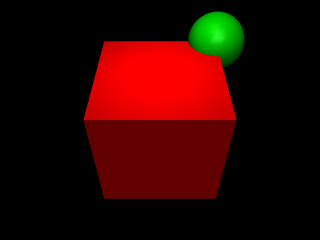

In [4]:
#@title A static model {vertical-output: true}

static_model = """
<mujoco>
  <worldbody>
    <light name="top" pos="0 0 1"/>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
physics = mujoco.Physics.from_xml_string(static_model)
pixels = physics.render()
PIL.Image.fromarray(pixels)

In [5]:
labmaze.defaults.__dict__.keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__file__', '__cached__', '__builtins__', 'MAX_ROOMS', 'ROOM_MIN_SIZE', 'ROOM_MAX_SIZE', 'RETRY_COUNT', 'EXTRA_CONNECTION_PROBABILITY', 'MAX_VARIATIONS', 'HAS_DOORS', 'SIMPLIFY', 'SPAWN_COUNT', 'SPAWN_TOKEN', 'OBJECT_COUNT', 'OBJECT_TOKEN'])

In [10]:
walker = ant.Ant()
print(labmaze.defaults.SPAWN_TOKEN)
maze_str = "**********\n*.....G..*\n*....P...*\n**********\n"
arena = DM_Maze_Arena(maze=labmaze.FixedMazeWithRandomGoals(maze_str))
print(arena._spawn_positions)
task = DM_Maze_Task(walker, None, arena, 1, enable_global_task_observables=True, randomize_spawn_rotation=False, randomize_spawn_position=False)

P
(array([ 1., -1.,  0.]),)


In [11]:
config = {
  "dm_env": DM_Maze_Env,
  "task": task,
  "random_state": np.random.RandomState(42),
  "strip_singleton_obs_buffer_dim": True,
  "time_limit": 10
}
env = DMEnvWrapper(config)
obs = env.reset({"absolute_position": [1, -1.0, 100]})
print({k: o.shape for k, o in obs.items()})
print(obs["absolute_position"])
imgs = []
for i in range(10):
  env.step(env.action_space.sample())
  pixels = []
  for camera_id in range(3):
    pixels.append(env.physics.render(camera_id=camera_id, width=240))
  display(PIL.Image.fromarray(np.hstack(pixels)))

AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
{'walker/appendages_pos': (12,), 'walker/bodies_pos': (39,), 'walker/bodies_quats': (52,), 'walker/body_height': (), 'walker/egocentric_camera': (64, 64, 3), 'walker/end_effectors_pos': (12,), 'walker/joints_pos': (8,), 'walker/joints_vel': (8,), 'walker/sensors_accelerometer': (3,), 'walker/sensors_force': (0,), 'walker/sensors_gyro': (3,), 'walker/sensors_torque': (0,), 'walker/sensors_touch': (9,), 'walker/sensors_velocimeter': (3,), 'walker/world_zaxis': (3,)}


KeyError: 'absolute_position'